# ReadWindCube

Este notebook tem como objetivo exemplificar a utilização do programa **ReadWindCube**. O **ReadWindCube** foi desenvolvido para facilitar a leitura e manipulação de dados do instrumento **Wind Cube LIDAR**, oferecendo funcionalidades para automação de análise e visualização desses dados.

Com o **ReadWindCube**, é possível carregar dados diretamente dos arquivos do Wind Cube, realizar cálculos estatísticos, gerar gráficos como a rosa dos ventos e exportar os resultados em formatos de fácil uso, como tabelas CSV. Essas funcionalidades são úteis para a elaboração de normas técnicas, relatórios e artigos científicos, proporcionando agilidade e precisão nas análises de dados de vento.

Neste notebook, abordaremos as principais funcionalidades do **ReadWindCube**, com exemplos práticos de uso.


### Leitura e manipulação de dados

O primeiro passo na utilização do programa envolve a leitura de um arquivo bruto de dados e sua manipulação. Para isso, o **ReadWindCube** utiliza as bibliotecas **Pandas** e **Xarray**:

- **Pandas** é responsável por ler o arquivo bruto tabulado do Wind Cube LIDAR.
- **Xarray** transforma os dados em um objeto multidimensional (3D), permitindo uma manipulação mais intuitiva e facilitada, semelhante a trabalhar com arquivos NetCDF.

In [1]:
# Primeiramente, importar o objeto ReadWindCubeAccessor
from ReadWindCube import ReadWindCubeAccessor

# Criar uma instância de ReadWindCubeAccessor e carregar o arquivo de exemplo
ds_accessor = ReadWindCubeAccessor("./WLS866-104_2024_08_01__00_00_00.rtd")  # Arquivo de exemplo
ds_accessor.load_data()

# Acessar diretamente o objeto xarray.Dataset
dataset = ds_accessor.dataset
print(dataset)

<xarray.Dataset> Size: 13MB
Dimensions:             (height: 7, time: 45262)
Coordinates:
  * time                (time) datetime64[ns] 362kB 2024-08-01T00:00:00.12000...
  * height              (height) int64 56B 40 50 60 70 100 120 150
Data variables:
    Wind Speed (m/s)    (height, time) float64 3MB 5.83 5.93 5.8 ... 4.0 3.94
    Wind Direction (°)  (height, time) float64 3MB 117.1 119.0 ... 108.5 106.0
    X-wind (m/s)        (height, time) float64 3MB -2.658 -2.875 ... -1.09
    Y-wind (m/s)        (height, time) float64 3MB 5.188 5.188 ... 3.788 3.788
    Z-wind (m/s)        (height, time) float64 3MB -23.04 -23.04 ... -19.98


Podemos ver que o objeto gerado possui as coordenadas **tempo** e **altura**, além de diferentes variáveis, como a **velocidade do vento**, suas componentes nos eixos **X, Y e Z**, e a **direção do vento** (em graus). 

### Importante:
A altura indicada está relativa ao nível do mar mais a altura do aparelho instalado. Por exemplo, se o Wind Cube está instalado a 100m do nível do mar, soma-se a altura do feixe de luz medido à altura de referência. 

Como o metadado do arquivo não especifica a altura de referência do aparelho, essa altura deve ser passada pelo usuário como argumento no momento de construir o dataset. Veja um exemplo abaixo:

In [2]:
# Criando uma instância do ReadWindCubeAccessor e carregando o arquivo com uma altura de referência de 100 metros
ds_accessor = ReadWindCubeAccessor("./WLS866-104_2024_08_01__00_00_00.rtd")
ds_accessor.load_data(reference_height=100)

# Acessar diretamente o objeto xarray.Dataset e verificar as alturas ajustadas
dataset = ds_accessor.dataset
print(dataset)

<xarray.Dataset> Size: 13MB
Dimensions:             (height: 7, time: 45262)
Coordinates:
  * time                (time) datetime64[ns] 362kB 2024-08-01T00:00:00.12000...
  * height              (height) int64 56B 140 150 160 170 200 220 250
Data variables:
    Wind Speed (m/s)    (height, time) float64 3MB 5.83 5.93 5.8 ... 4.0 3.94
    Wind Direction (°)  (height, time) float64 3MB 117.1 119.0 ... 108.5 106.0
    X-wind (m/s)        (height, time) float64 3MB -2.658 -2.875 ... -1.09
    Y-wind (m/s)        (height, time) float64 3MB 5.188 5.188 ... 3.788 3.788
    Z-wind (m/s)        (height, time) float64 3MB -23.04 -23.04 ... -19.98


### Seleção de tempos e alturas específicas

Uma vez que os dados são carregados no formato `xarray.Dataset`, o **ReadWindCube** oferece métodos fáceis e eficientes para selecionar intervalos de tempo e alturas específicas. Isso pode ser feito utilizando os métodos `.sel` (seleção por coordenadas) e `.isel` (seleção por índices).

#### Método `.sel`: Seleção por coordenadas

O método `.sel` permite selecionar dados com base nos valores exatos das coordenadas, como datas e alturas específicas. Por exemplo, você pode selecionar dados para um período de tempo ou uma altura específica em metros.

**Exemplo: Seleção por intervalo de tempo e altura específica**

In [3]:
# Selecionando dados entre 2024-08-01 00:00:00 e 2024-08-01 02:00:00 para a altura de 50 metros
subset_accessor = ds_accessor.sel(time=slice('2024-08-01T00:00:00', '2024-08-01T02:00:00'), height=150)
print(subset_accessor.dataset)

<xarray.Dataset> Size: 432kB
Dimensions:             (time: 9002)
Coordinates:
  * time                (time) datetime64[ns] 72kB 2024-08-01T00:00:00.120000...
    height              int64 8B 150
Data variables:
    Wind Speed (m/s)    (time) float64 72kB 5.3 5.46 5.41 nan ... 5.95 6.17 6.32
    Wind Direction (°)  (time) float64 72kB 120.5 123.2 123.5 ... 136.4 137.7
    X-wind (m/s)        (time) float64 72kB -2.69 -2.991 -2.991 ... -4.47 -4.671
    Y-wind (m/s)        (time) float64 72kB 4.571 4.571 4.514 ... 4.255 4.255
    Z-wind (m/s)        (time) float64 72kB -23.32 -23.32 -23.32 ... 16.69 16.69


Neste exemplo, selecionamos o intervalo de tempo desejado usando a função `slice`, e a altura é escolhida diretamente com o valor exato (neste caso, 150 metros). Isso permite visualizar os dados apenas para aquele intervalo e altura.

#### Método `.isel`: Seleção por índices 

O método `.isel` permite a seleção de dados com base nos índices das coordenadas, ou seja, você pode escolher as posições numéricas das coordenadas de tempo e altura em vez de seus valores exatos.

In [4]:
# Selecionando os primeiros 100 passos de tempo e o primeiro índice de altura
subset_accessor = ds_accessor.isel(time=slice(0, 100), height=0)
print(subset_accessor.dataset)

<xarray.Dataset> Size: 5kB
Dimensions:             (time: 100)
Coordinates:
  * time                (time) datetime64[ns] 800B 2024-08-01T00:00:00.120000...
    height              int64 8B 140
Data variables:
    Wind Speed (m/s)    (time) float64 800B 5.83 5.93 5.8 nan ... 5.77 nan 5.51
    Wind Direction (°)  (time) float64 800B 117.1 119.0 119.7 ... nan 111.2
    X-wind (m/s)        (time) float64 800B -2.658 -2.875 -2.875 ... nan -1.99
    Y-wind (m/s)        (time) float64 800B 5.188 5.188 5.037 ... 5.14 nan 5.14
    Z-wind (m/s)        (time) float64 800B -23.04 -23.04 -23.04 ... -29.1 -29.1


Neste exemplo, estamos selecionando os primeiros 100 passos de tempo e o primeiro índice de altura no dataset. O primeiro índice de altura corresponde à menor altura no dataset (por exemplo, se as alturas são 50, 60 e 70 metros, o índice 0 corresponde a 50 metros).

### Cálculo do desvio padrão da velocidade do vento e remoção de tendência

O **ReadWindCube** oferece uma função útil para calcular o desvio padrão da velocidade do vento, após remover tendências dos dados. Essa operação é particularmente útil para identificar a variabilidade do vento em diferentes alturas e durante diferentes intervalos de tempo, à partir de uma série estacionária.

#### Função `compute_std_detrended_data`

Essa função realiza o cálculo do desvio padrão para uma variável (por padrão, a velocidade do vento) em uma altura específica, utilizando uma janela deslizante para suavizar as variações e remover tendências de longo prazo.

#### Parâmetros de entrada:
- **height** (*int*): Altura em metros para a qual o desvio padrão será calculado.
- **variable** (*str*): Nome da variável para a qual o cálculo será realizado (o padrão é 'Wind Speed (m/s)').
- **window_size** (*int*): Tamanho da janela deslizante (em número de passos no tempo) para o cálculo do desvio padrão. O padrão é 600 passos no tempo, mas pode ser ajustado conforme necessário.

#### Exemplo prático:

Abaixo, calculamos o desvio padrão com remoção de tendência para a velocidade do vento a 40 metros de altura e, em seguida, plotamos o resultado ao longo do tempo.

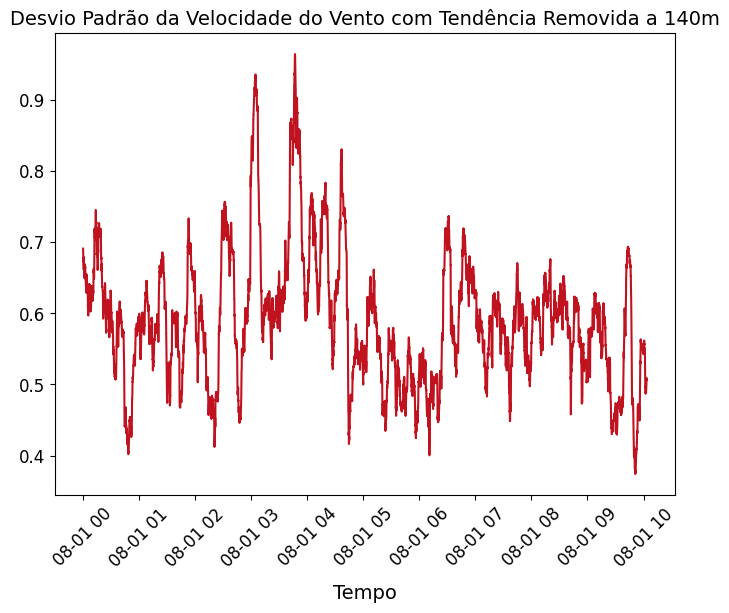

In [5]:
# Calcular o desvio padrão com remoção de tendência para a velocidade do vento a 140 metros
std_detrended_ws140m = ds_accessor.compute_std_detrended_data(140, 'Wind Speed (m/s)')

# Importar biblioteca de plotagem
import matplotlib.pyplot as plt

# Plotar o desvio padrão ao longo do tempo
plt.figure(figsize=(8,6))
plt.plot(dataset.time.values, std_detrended_ws140m.values, c='#c1121f')
plt.title('Desvio Padrão da Velocidade do Vento com Tendência Removida a 140m', fontsize=14)
plt.xlabel('Tempo', labelpad=10, fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Exemplo: Cálculo do desvio padrão com remoção de tendência e plotagem da velocidade do vento a 140 metros

Agora, vamos plotar a série temporal da velocidade do vento real e do desvio padrão calculado para podermos comparar visualmente ambas as séries

<xarray.DataArray 'Wind Speed (m/s)' (time: 45262)> Size: 362kB
array([5.83, 5.93, 5.8 , ..., 4.59, 4.61, 4.57])
Coordinates:
  * time     (time) datetime64[ns] 362kB 2024-08-01T00:00:00.120000 ... 2024-...
    height   int64 8B 140


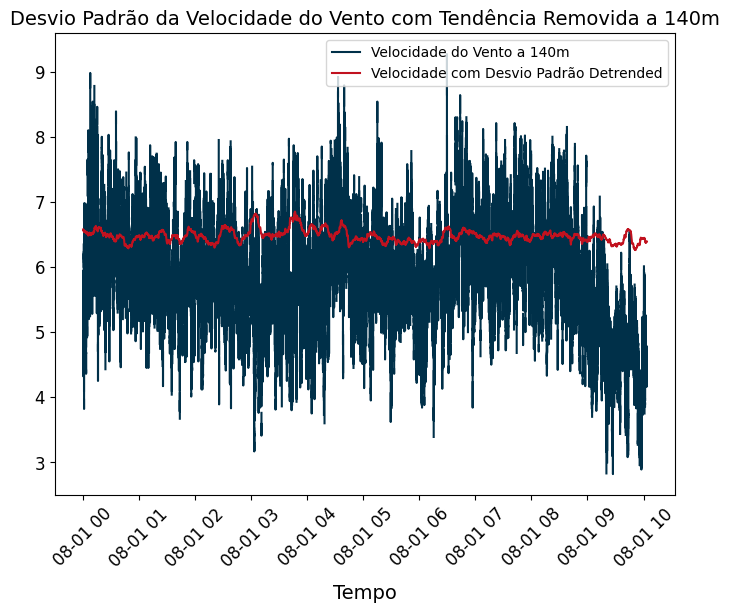

In [6]:
# Calcular o desvio padrão com remoção de tendência para a velocidade do vento a 140 metros
std_detrended_ws140m = ds_accessor.compute_std_detrended_data(140, 'Wind Speed (m/s)')

# Velocidade real a 140 metros
ws140m = dataset["Wind Speed (m/s)"].sel(height=140)
print(ws140m)

# Importar biblioteca de plotagem
import matplotlib.pyplot as plt

# Plotar o desvio padrão ao longo do tempo junto com a velocidade do vento original
plt.figure(figsize=(8,6))
plt.plot(dataset.time.values, ws140m.values, c='#003049', label='Velocidade do Vento a 140m')
plt.plot(dataset.time.values, (std_detrended_ws140m + ws140m.mean()).values, c='#c1121f', label='Velocidade com Desvio Padrão Detrended')
plt.title('Desvio Padrão da Velocidade do Vento com Tendência Removida a 140m', fontsize=14)
plt.xlabel('Tempo', labelpad=10, fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()


### Plotagem da velocidade do vento em uma única altura

Para facilitar a visualização da velocidade do vento, o **ReadWindCube** possui uma função embutida chamada `plot_variable`. Com esta função, o usuário pode facilmente gerar gráficos de variáveis, como a velocidade do vento, para um nível específico de altura.

#### Função `plot_variable`

A função `plot_variable` gera um gráfico simples da variável desejada para a altura especificada. Isso é útil quando o usuário quer visualizar rapidamente a evolução da velocidade do vento ao longo do tempo para uma única altura, sem a necessidade de realizar operações adicionais.

#### Parâmetros de entrada:
- **height** (*int*): A altura em metros para a qual a variável será plotada.
- **variable** (*str*): A variável a ser plotada (por padrão, 'Wind Speed (m/s)').

#### Exemplo prático:

Neste exemplo, vamos visualizar: velocidade do vento, velocidade do vento na direção X e direção do vento, a uma altura de 140 metros. Além da plotagem básica, o usuário pode personalizar o gráfico gerado através do objeto `ax`, que representa o eixo do gráfico. Abaixo estão algumas customizações possíveis:

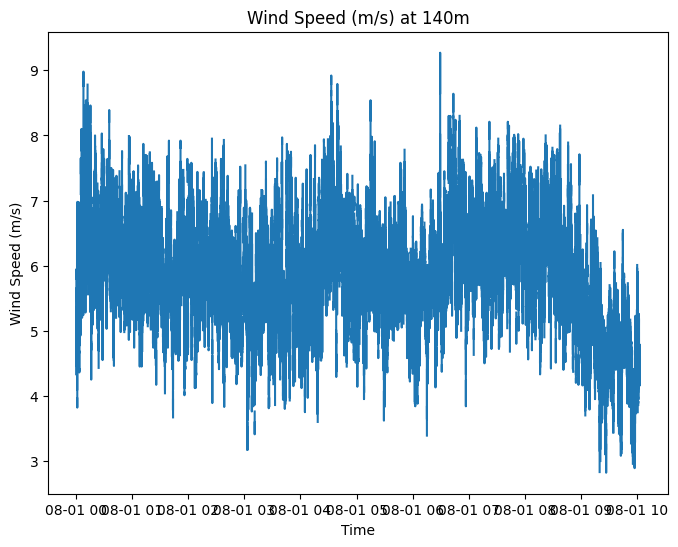

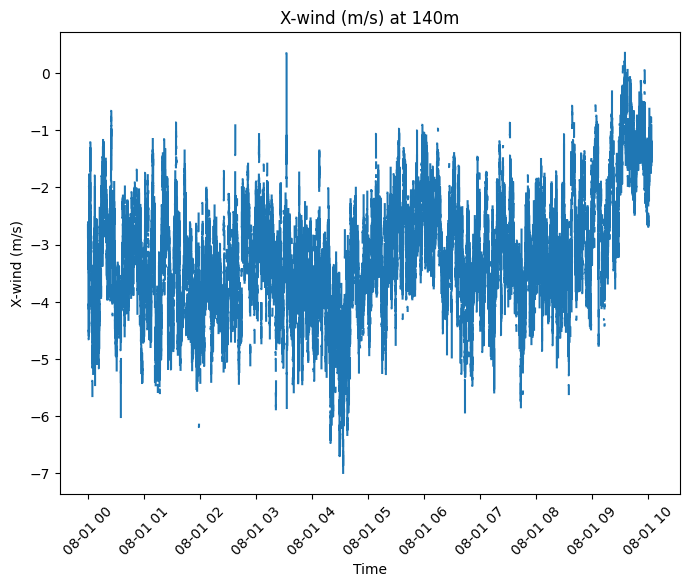

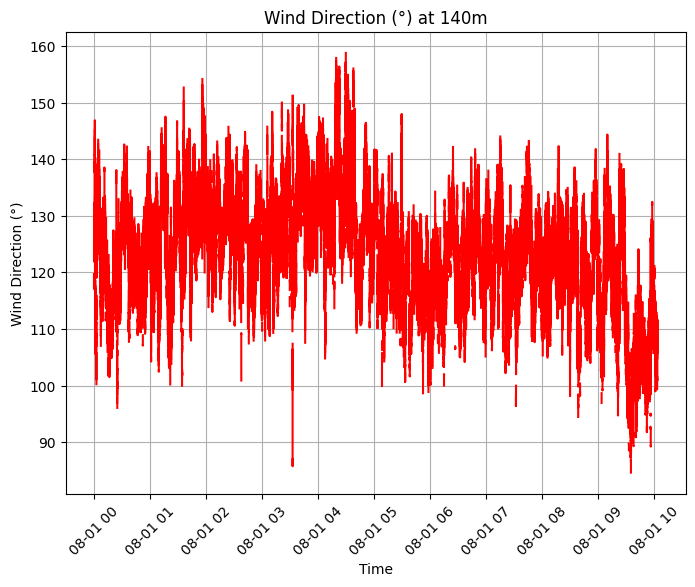

In [7]:
# Velocidade do vento
ax = ds_accessor.plot_variable(140, 'Wind Speed (m/s)')

# Componente X
ax = ds_accessor.plot_variable(140, 'X-wind (m/s)')
ax.tick_params(axis='x', labelrotation=45)  # Rotaciona os rótulos do eixo X

# Direção do vento
ax = ds_accessor.plot_variable(140, 'Wind Direction (°)')
ax.tick_params(axis='x', labelrotation=45)
ax.grid(True)  # Ativa o grid no gráfico
line = ax.lines[0] # Capturando a linha gerada
line.set_color('red')  # Define a cor da linha para vermelho

### Obter dados de velocidade e direção do vento em formato de DataFrame

O **ReadWindCube** oferece uma função para extrair os dados de velocidade e direção do vento para uma altura específica e convertê-los diretamente em um `pandas.DataFrame`. Isso é útil quando se deseja trabalhar com os dados em um formato mais tabular, por exemplo, para fazer cálculos adicionais ou exportar os dados para um arquivo CSV.

#### Função `get_wind_df`

A função `get_wind_df` retorna um `DataFrame` com as colunas 'Wind Speed (m/s)' e 'Wind Direction (°)' para a altura especificada.

#### Parâmetros de entrada:
- **height** (*int*): A altura em metros para a qual os dados serão extraídos.

#### Exemplo prático:

Neste exemplo, vamos obter a velocidade e a direção do vento a 40 metros e visualizar os primeiros dados retornados:

In [8]:
# Obter um DataFrame com velocidade e direção do vento a 40 metros
wind_df = ds_accessor.get_wind_df(140)

# Exibir o DataFrame
print(wind_df.head())

                         Wind Speed (m/s)  Wind Direction (°)
Time                                                         
2024-08-01 00:00:00.120              5.83              117.13
2024-08-01 00:00:00.920              5.93              119.00
2024-08-01 00:00:01.720              5.80              119.72
2024-08-01 00:00:02.520               NaN                 NaN
2024-08-01 00:00:03.320              5.94              121.97


### Visualização de Rosas dos Ventos

Uma funcionalidade bastante útil do ReadWindCube é a possibilidade de gerar rosas dos ventos a partir dos dados de velocidade e direção do vento em diferentes alturas. A função `plot_wind_rose` permite que você visualize uma rosa dos ventos para uma altura específica, com a possibilidade de calcular médias em janelas de tempo específicas.

#### Parâmetros da Função `plot_wind_rose` 

* **`height`**: Altura (em metros) para a qual será gerada a rosa dos ventos.
* **`averaging_window`**: (Opcional) Janela de tempo para calcular a média dos dados. O formato segue as regras do Pandas, como `'1h'` para média horária, `'10T'` para média a cada 10 minutos, etc.
* **`colormap`**: (Opcional) O mapa de cores utilizado para a plotagem. O valor padrão é `'viridis'`, mas você pode escolher diferentes colormaps como `'coolwarm'`, `'plasma'`, etc.
* **`period`**: (Opcional) Um período para filtrar os dados. Pode ser um mês específico (por exemplo, `'January'`, `'February'`) ou uma estação do ano (usando os códigos meteorológicos `'DJF'` para verão austral, `'JJA'` para inverno austral, etc.).
* **Retorno**: A função retorna o objeto `WindroseAxes` para que você possa modificar ou salvar o gráfico posteriormente.

#### Exemplo 1: Plotar a Rosa dos Ventos sem Média

No exemplo abaixo, plotamos a rosa dos ventos para a altura de 140 metros sem realizar médias temporais.

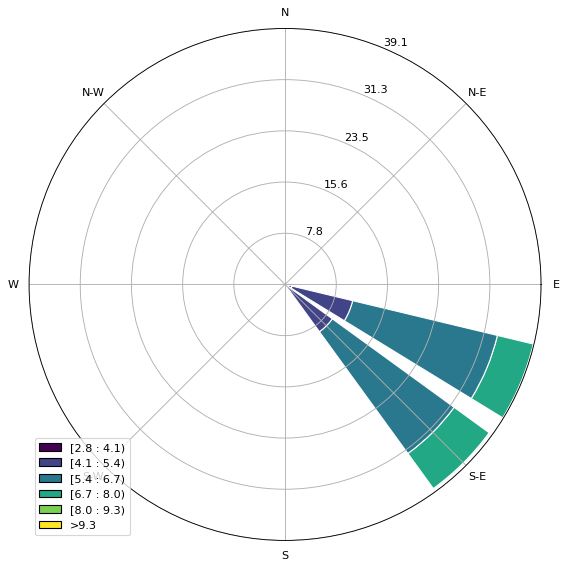

In [9]:
# Plotar a rosa dos ventos para a altura de 140 metros sem média temporal
ds_accessor.plot_wind_rose(140)
plt.show()

#### Exemplo 2: Plotar a Rosa dos Ventos com Média Temporal 

A função `plot_wind_rose` também permite calcular médias para diferentes janelas de tempo. Abaixo, mostramos como calcular a média de velocidade e direção do vento a cada 1 hora e, em seguida, plotar a rosa dos ventos para a altura de 40 metros. Além disso, você pode modificar o título e salvar a figura posteriormente.

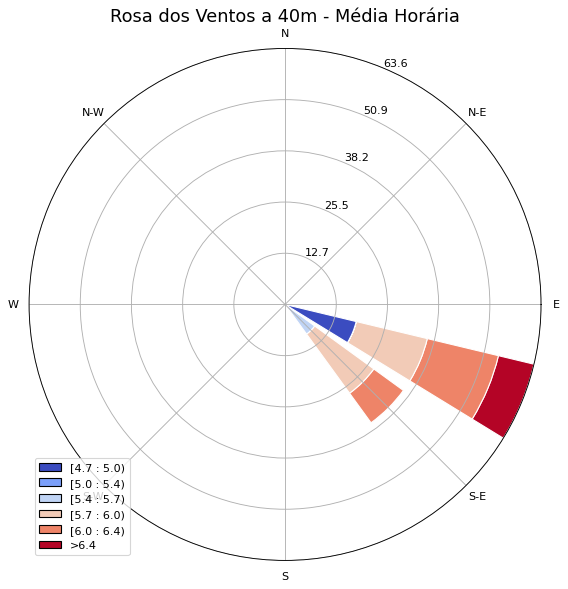

In [10]:
# Plotar a rosa dos ventos para a altura de 140 metros com média horária e um mapa de cores diferente
ax = ds_accessor.plot_wind_rose(140, averaging_window='1h', colormap='coolwarm')
ax.set_title("Rosa dos Ventos a 40m - Média Horária", fontsize=16)
plt.show()

# Salvar a figura
ax.figure.savefig('rosa_dos_ventos_140m_horario.png')

### Geração de Tabela de Distribuição de Vento

A função `generate_wind_distribution_table` tem como objetivo gerar uma tabela de distribuição cumulativa de vento. Cada linha representa a frequência cumulativa para velocidades de vento abaixo de um determinado limite, enquanto cada coluna representa direções de vento agrupadas em bins de ±15° ao redor de um valor central (por exemplo, 30°, 60°, etc.).

Essa função é útil para análise de frequência de vento em diferentes direções e velocidades e pode ser usada para gerar tabelas como a mostrada anteriormente.

#### Parâmetros:
- **height (int)**: A altura em metros na qual calcular a distribuição de vento.
- **speed_thresholds (list, opcional)**: Lista com os limites de velocidade do vento (em m/s). O padrão é [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32].
- **direction_bins (list, opcional)**: Lista com os limites de bins de direção do vento (em graus). O padrão é [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360].
- **period (str, opcional)**: Um parâmetro opcional para filtrar dados de uma estação meteorológica específica ou mês. As estações podem ser representadas pelas siglas "DJF" (Verão), "MAM" (Outono), "JJA" (Inverno), e "SON" (Primavera). Além disso, também pode ser especificado um mês, como "January" (Janeiro), "February" (Fevereiro), etc.

#### Retorno:
- **pd.DataFrame**: Um DataFrame contendo a tabela de distribuição de vento, onde as linhas são os limites de velocidade do vento cumulativos e as colunas são os bins de direção do vento, além de uma coluna "Omni" para a soma das frequências em todas as direções.

#### Exemplo de Uso:

Abaixo, vamos exemplificar o uso da função para gerar a tabela de distribuição de vento na altura de 140 metros para o conjunto de dados completo:

In [11]:
# Geração da tabela de distribuição de vento a 140 metros de altura
wind_distribution_table = ds_accessor.generate_wind_distribution_table(140)

# Exibição da tabela gerada
print(wind_distribution_table)

            0    30    60     90    120    150   180   210   240   270   300  \
< 2      0.00  0.00  0.00   0.00   0.00   0.00  0.00  0.00  0.00  0.00  0.00   
< 4      0.00  0.00  0.00  19.61  76.47   3.92  0.00  0.00  0.00  0.00  0.00   
< 6      0.00  0.00  0.00   6.46  81.88  11.66  0.00  0.00  0.00  0.00  0.00   
< 8      0.00  0.00  0.00   3.93  85.06  11.01  0.00  0.00  0.00  0.00  0.00   
< 10     0.00  0.00  0.00   3.92  85.05  11.04  0.00  0.00  0.00  0.00  0.00   
< 12     0.00  0.00  0.00   3.92  85.05  11.04  0.00  0.00  0.00  0.00  0.00   
< 14     0.00  0.00  0.00   3.92  85.05  11.04  0.00  0.00  0.00  0.00  0.00   
< 16     0.00  0.00  0.00   3.92  85.05  11.04  0.00  0.00  0.00  0.00  0.00   
< 18     0.00  0.00  0.00   3.92  85.05  11.04  0.00  0.00  0.00  0.00  0.00   
< 20     0.00  0.00  0.00   3.92  85.05  11.04  0.00  0.00  0.00  0.00  0.00   
< 22     0.00  0.00  0.00   3.92  85.05  11.04  0.00  0.00  0.00  0.00  0.00   
< 24     0.00  0.00  0.00   3.92  85.05 

O arquivo que estávamos usando para teste possui, na verdade, dados apenas para as primeiras 10 horas do dia 08 de agosto de 2024. Por conta disso, a tabela de distribuição gerada anteriormente não apresentou muitos valores, o que pode dificultar uma análise mais abrangente da funcionalidade. Para podermos ter uma visão mais clara e completa do potencial dessa função, utilizaremos agora um arquivo de teste criado especificamente para este guia. Este novo arquivo contém dados fictícios para o ano de 2023, com velocidades de vento geradas a partir de uma distribuição Weibull aleatória, e uma resolução temporal de 1 hora. Com esse novo arquivo, iremos criar um novo objeto `ReadWindCubeAccessor` e construir a tabela de distribuição de vento para análise.

In [12]:
# Criando o novo objeto ReadWindCubeAccessor com o arquivo de teste fictício
ds_accessor = ReadWindCubeAccessor("./dummy_data_2023.rtd")

# Carregar os dados do arquivo de teste
ds_accessor.load_data(reference_height=100)

# Gerar a tabela de distribuição de vento a 140 metros de altura para o ano de 2023
wind_distribution_table_test = ds_accessor.generate_wind_distribution_table(140)

# Exibir a tabela gerada
print(wind_distribution_table_test)

             0     30     60     90    120    150    180    210    240    270  \
< 2       4.09  10.69   8.18   8.18  10.69   6.29   8.81   8.18   7.86  10.69   
< 4       4.73   9.54  10.25   9.38   8.52   9.15   8.04   8.44   8.44   8.04   
< 6       4.67   9.72   9.60   8.67   8.55   8.67   8.32   8.94   8.48   8.48   
< 8       4.38   9.54   9.36   8.66   8.45   8.48   8.73   8.45   8.76   9.09   
< 10      4.35   9.51   9.17   8.98   8.46   8.63   8.38   8.55   8.53   8.95   
< 12      4.46   9.26   9.13   8.90   8.27   8.48   8.39   8.78   8.64   8.95   
< 14      4.44   9.45   9.03   8.86   8.33   8.72   8.39   8.60   8.62   8.67   
< 16      4.39   9.43   8.77   8.88   8.36   8.67   8.57   8.54   8.61   8.86   
< 18      4.47   9.50   8.76   8.88   8.34   8.58   8.49   8.60   8.73   8.86   
< 20      4.42   9.48   8.77   8.94   8.33   8.59   8.53   8.60   8.70   8.86   
< 22      4.41   9.44   8.79   8.97   8.32   8.57   8.50   8.57   8.72   8.87   
< 24      4.43   9.45   8.80

#### Exemplo de Uso: Filtrando por Mês ou Estação 
Além de gerar a tabela de distribuição para o conjunto de dados completo, podemos também filtrar por um período específico, como um mês ou uma estação do ano. 

##### Exemplo: Filtrando por Mês

In [13]:
# Gerar a tabela de distribuição de vento para o mês de Janeiro
wind_distribution_january = ds_accessor.generate_wind_distribution_table(140, period='January')
print(wind_distribution_january)

             0     30     60     90    120    150    180    210    240    270  \
< 2       6.25   9.38   9.38   6.25   3.12   3.12  12.50   9.38   3.12  12.50   
< 4       4.81   7.69  10.58   5.77   7.69   7.69   8.65  11.54   7.69   6.73   
< 6       5.07  10.14   9.68   6.91   6.91   8.76   7.37  10.14   7.37   9.68   
< 8       4.42  10.09   9.46   7.89   6.94   7.89   7.89   9.78   7.89   9.78   
< 10      5.08  10.38   9.49   8.17   7.06   7.06   7.73  10.15   7.06   9.05   
< 12      5.16   9.94   9.39   8.29   7.00   7.18   7.18  11.42   7.37   8.84   
< 14      5.47  10.45   9.12   8.13   6.80   7.63   6.97  10.78   7.79   8.46   
< 16      5.60  10.42   8.86   8.40   6.69   7.47   7.15  10.73   7.31   8.55   
< 18      5.74   9.87   8.98   8.39   6.77   7.22   7.22  11.19   7.22   8.98   
< 20      5.64   9.68   8.96   8.67   6.79   7.23   7.51  10.98   7.23   9.10   
< 22      5.70   9.69   8.83   8.69   6.98   7.12   7.41  11.11   7.12   8.97   
< 24      5.70   9.69   8.83

##### Exemplo: Filtrando por Estação (Verão)

In [14]:
# Gerar a tabela de distribuição de vento para o verão (Dezembro, Janeiro, Fevereiro)
wind_distribution_summer = ds_accessor.generate_wind_distribution_table(140, period='DJF')
print(wind_distribution_summer)

             0     30     60     90    120    150    180    210    240    270  \
< 2       3.75  10.00   7.50   5.00  13.75   2.50   7.50  10.00   8.75  11.25   
< 4       3.19   7.09  10.64   6.03   9.22   9.22   7.45  10.64   8.51   8.87   
< 6       4.77   9.38   9.54   6.91   8.55   9.54   7.40   9.05   8.06   9.38   
< 8       4.15   9.16   9.27   7.99   8.09   8.84   8.09   8.41   8.73   9.90   
< 10      4.41   9.44   9.36   8.66   7.89   8.20   7.81   8.43   8.20  10.05   
< 12      4.69   9.24   9.44   8.60   7.83   8.02   7.57   9.05   8.22   9.82   
< 14      4.58   9.67   9.61   8.41   7.72   8.07   7.55   8.70   8.41   9.38   
< 16      4.54   9.67   9.35   8.55   7.69   7.91   8.01   8.49   8.55   9.62   
< 18      4.74   9.58   9.28   8.41   7.65   7.80   7.95   8.72   8.77   9.73   
< 20      4.66   9.47   9.22   8.52   7.57   7.97   8.07   8.72   8.82   9.72   
< 22      4.71   9.47   9.17   8.48   7.59   7.88   8.03   8.73   8.73   9.67   
< 24      4.79   9.43   9.23

Similarmente, nós agora podemos fazer o gráfico da rosa dos ventos para um mês ou estação específico:

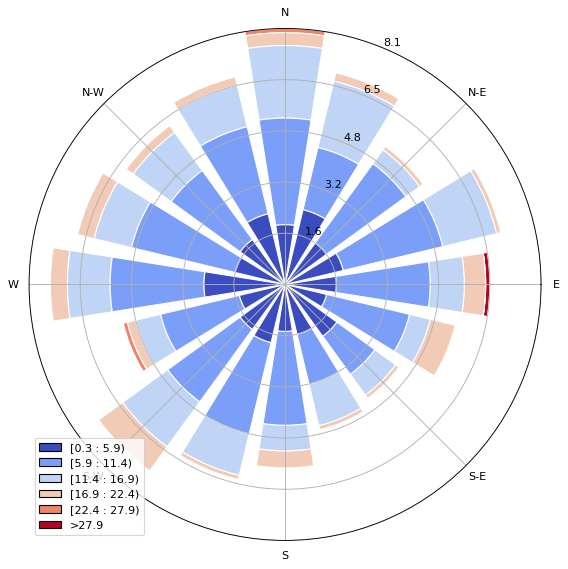

In [15]:
# Plotar a rosa dos ventos para 140 metros no mês de janeiro
ax = ds_accessor.plot_wind_rose(140, colormap='coolwarm', period='January')
plt.show()